# Request
Show us a visual representation that explores danceability, popularity, and song key. Potential questions that could be asked are: What song key has the most danceability? How does popularity and song key relate? Are the most popular songs also the most danceable?

# Initial Setup using Averages
 - Load data from "music_genre.csv" in folder using pandas. 
 - Save the data frame back to SQLite for convenience. Note that when we pull data out of sqlite we're normalizing popularity to make it easier to chart.
 - Plot items using pyplot from matlab.
 - (Stretch Goal) Output to tables, coloring max/min values if possible.

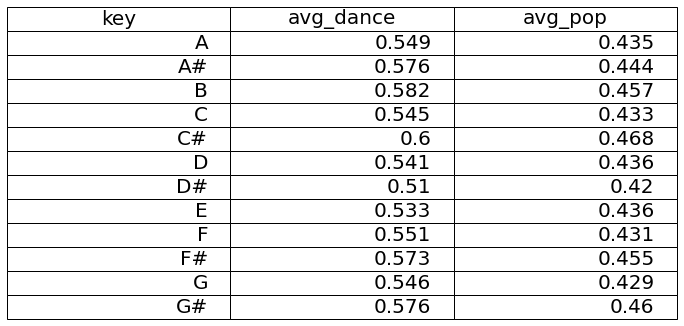

The minimum average dance value is:  0.51 by key  D#
The maximum average dance value is:  0.6 by key  C#
The minimum average pop value is:  0.42 by key  D#
The maximum average pop value is:  0.468 by key  C#


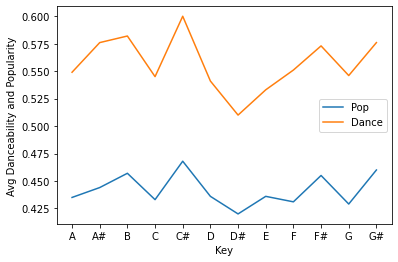

In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import pandasql as ps
import sqlite3
import numpy as np

# read csv
music_genre = pd.read_csv('music_genre.csv')

# create an in-memory sqlite database and save the data frame to it
conn = sqlite3.connect(":memory:")
music_genre.to_sql(name='music', con=conn)
cur = conn.cursor()

# get the average by key
# we multiply the popularity by 0.01 to try and normalize (produce a value between 0 and 1)
query = """SELECT 
                key,
                ROUND(AVG(danceability), 3) avg_dance, 
                ROUND(AVG(popularity) * 0.01, 3) avg_pop
            FROM 
                music
            WHERE
                danceability IS NOT NULL
            AND
                popularity IS NOT NULL                 
            GROUP BY 
                key"""

# grab average danceability, popularity, and key from the table we just created
# we'll use this later in the plots below
cur.execute(query)
avg_result = cur.fetchall()

avg_danceability = []
avg_popularity = []
avg_song_key = []

# iterate over the rows return and account for NULLs in the results
for row in avg_result:
    item_key = row[0]
    if item_key is None:
        avg_song_key.append("?")
    else:
        avg_song_key.append(item_key)
    item_dancebility = row[1]
    if item_dancebility is None:
        avg_danceability.append(0)
    else: 
        avg_danceability.append(item_dancebility)
    item_pop = row[2]    
    if item_pop is None:
        avg_popularity.append(0)
    else:
        avg_popularity.append(item_pop)
   
# use pandas to get data frame from SQL
# doing this to try and feed an object that works with matplotlib
df = pd.read_sql(query, conn)

# attempt to create a backing color table to highlight min/max
# spending too much time on trying to make the RGBW values work, commenting out for now

# need numeric values = leave the song key as 1
# color_df = ps.sqldf("SELECT 1, avg_dance, avg_pop from df")

# round the values to 2 places
#colVal = np.around(color_df, 2)

# attempt to normalize the values between 0 and 1
#norm = plt.Normalize(colVal['avg_dance'].min(), colVal['avg_pop'].max())

# attempt to create color map
#colors = plt.cm.hot(norm)

# https://www.statology.org/matplotlib-table/
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

# attempt to apply RBG colors to table
# table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellColours=colors)
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

# https://stackoverflow.com/questions/15514005/how-to-change-the-tables-fontsize-with-matplotlib-pyplot
table.set_fontsize(20)
table.scale(2, 2)
plt.show()   

# output some quick observations
print('The minimum average dance value is: ', str(df['avg_dance'].min()) , 'by key ' , df.loc[df['avg_dance'] == df['avg_dance'].min()]['key'].to_string(index=False))
print('The maximum average dance value is: ', str(df['avg_dance'].max()) , 'by key ' , df.loc[df['avg_dance'] == df['avg_dance'].max()]['key'].to_string(index=False))

print('The minimum average pop value is: ', str(df['avg_pop'].min()) , 'by key ' , df.loc[df['avg_pop'] == df['avg_pop'].min()]['key'].to_string(index=False))
print('The maximum average pop value is: ', str(df['avg_pop'].max()) , 'by key ' , df.loc[df['avg_pop'] == df['avg_pop'].max()]['key'].to_string(index=False))

# https://datascienceparichay.com/article/plot-a-line-chart-in-python-with-matplotlib/
# not sure if a line graph is the best visual here, because we're not doing changes over time
plt.plot(avg_song_key, avg_popularity)
plt.plot(avg_song_key, avg_danceability)
plt.xlabel("Key")
plt.ylabel("Avg Danceability and Popularity")
plt.legend(["Pop","Dance"])
plt.show()

# Average Danceability versus Song Key

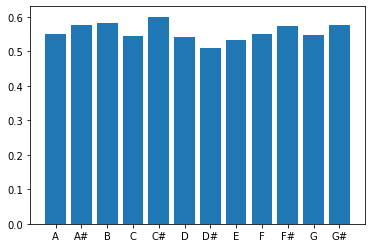

In [78]:
plt.bar(avg_song_key, avg_danceability)
plt.show()

# Average Popularity versus Song Key


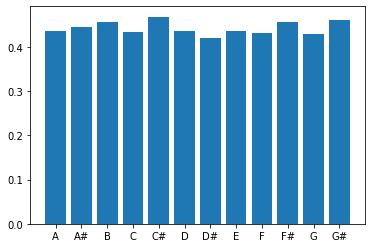

In [79]:
plt.bar(avg_song_key, avg_popularity)
plt.show()

# Breakdown by Key
Looking at min, max, and average for every key.

## Code

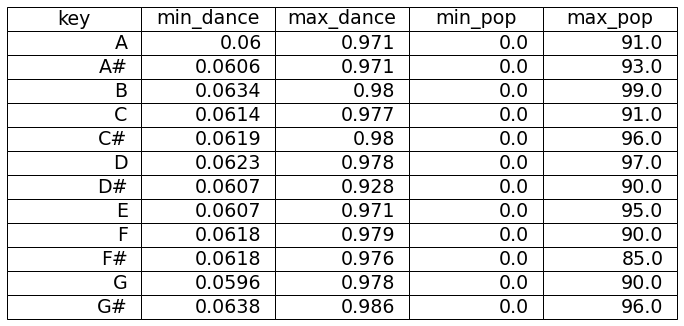

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# grab danceability, popularity, and key from the table we just created
query = """SELECT 
            key,
            MIN(danceability) min_dance, 
            MAX(danceability) max_dance, 
            MIN(popularity) min_pop, 
            MAX(popularity) max_pop
        FROM 
            music
        WHERE
            danceability IS NOT NULL
        AND
            popularity IS NOT NULL                     
        GROUP BY 
            key"""

# print(pd.read_sql_query(query, conn))
df = pd.read_sql(query, conn)

# https://www.statology.org/matplotlib-table/
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
table.set_fontsize(20)
table.scale(2, 2)
plt.show()

